# DFT Cycles

In [64]:
from processing_utils import number_of_DFT_cycles
from pathlib import Path
import json
import matplotlib.pyplot as plt
from collections import Counter

In [65]:
optimization_strategy = 'forces'

dft_path = Path(f"DFT/experiments_{optimization_strategy}/")

num_cycles = {}

for molecule in dft_path.iterdir():
    if molecule.is_dir():
        base_log = molecule / "base" / "DFT" / "dft_parameters.out"
        optimized_log = molecule / "optimized" / "DFT" / "dft_parameters.out"

        base_num_cycles = number_of_DFT_cycles(base_log)
        optimized_num_cycles = number_of_DFT_cycles(optimized_log)

        num_cycles[molecule.name] = {
            "base": base_num_cycles,
            "optimized": optimized_num_cycles,
        }

In [66]:
with open("DFT/num_cycles.json", "w") as f:
    json.dump(num_cycles, f, indent=4)

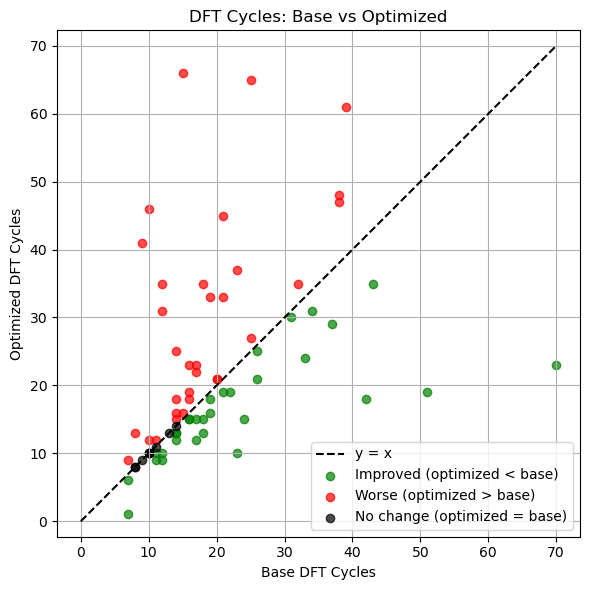

In [67]:
base = []
optimized = []
labels = []

# Collect and split points
for mol, v in num_cycles.items():
    b, o = v["base"], v["optimized"]
    base.append(b)
    optimized.append(o)
    labels.append(mol)

# Split into two groups
above_x = [(b, o) for b, o in zip(base, optimized) if o > b and o >= 0 and b >= 0]
below_x = [(b, o) for b, o in zip(base, optimized) if o < b and o > 0 and b >= 0]
on_x = [(b, o) for b, o in zip(base, optimized) if o == b and o > 0 and b >= 0]
failed_x = [(b, o) for b, o in zip(base, optimized) if o < 0 or b < 0]

# Unpack
above_base, above_opt = zip(*above_x) if above_x else ([], [])
below_base, below_opt = zip(*below_x) if below_x else ([], [])
on_base, on_opt = zip(*on_x if on_x else ([], []))

# Plot
plt.figure(figsize=(6, 6))
plt.plot([0, max(base)], [0, max(base)], "k--", label="y = x")

plt.scatter(
    below_base,
    below_opt,
    color="green",
    label=f"Improved (optimized < base)",
    alpha=0.7,
)
plt.scatter(
    above_base, above_opt, color="red", label="Worse (optimized > base)", alpha=0.7
)
plt.scatter(
    on_base, on_opt, color="black", label="No change (optimized = base)", alpha=0.7
)


plt.xlabel("Base DFT Cycles")
plt.ylabel("Optimized DFT Cycles")
plt.title("DFT Cycles: Base vs Optimized")
plt.legend(loc="lower right")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()

plt.savefig("DFT/num_cycles_plot.svg", dpi=300, bbox_inches="tight")
plt.show()

In [68]:
print(f"Percent got worse: {len(above_x) / len(num_cycles) * 100:.2f}%")
print(f"Percent got better: {len(below_x) / len(num_cycles) * 100:.2f}%")
print(f"Percent unchanged: {len(on_x) / len(num_cycles) * 100:.2f}%")

Percent got worse: 36.36%
Percent got better: 35.23%
Percent unchanged: 10.23%


In [69]:
print(
    f"Average optimized cycles: {sum(optimized) / len(optimized):.2f} "
)
print(
    f"Average base cycles: {sum(base) / len(base):.2f} "
)

Average optimized cycles: 18.61 
Average base cycles: 18.20 


In [70]:
failed_counter = Counter()
for b, o in failed_x:
    if b < 0 and o < 0:
        failed_counter["both_failed"] += 1
    elif b < 0:
        failed_counter["base_failed"] += 1
    elif o < 0:
        failed_counter["optimized_failed"] += 1

# print percent converged for each category
print(f"Failed base: {(len(num_cycles) - failed_counter['base_failed']) / len(num_cycles) * 100:.2f}%")
print(f"Failed optimized: {(len(num_cycles) - failed_counter['optimized_failed']) / len(num_cycles) * 100:.2f}%")
print(f"Failed both: {failed_counter['both_failed'] / len(num_cycles) * 100:.2f}%")

Failed base: 95.45%
Failed optimized: 93.18%
Failed both: 5.68%


## Number of Cycles Improvement vs Max Atomic Force Improvement

[('CPxSi3H7_236', {'num_cycles_improvement': 9, 'num_cycles_improvement_percent': 0.2727272727272727, 'max_atomic_force_improvement': 0.07492942472729583}), ('COP2SiH2_69', {'num_cycles_improvement': 3, 'num_cycles_improvement_percent': 0.15789473684210525, 'max_atomic_force_improvement': 0.07267813350749158}), ('COPxSiSxH3_946', {'num_cycles_improvement': -14, 'num_cycles_improvement_percent': -0.7368421052631579, 'max_atomic_force_improvement': 0.05866623905625234}), ('CPxSSiSxH3_658', {'num_cycles_improvement': -10, 'num_cycles_improvement_percent': -0.2631578947368421, 'max_atomic_force_improvement': 0.04610915505055204}), ('CSiSx3H8_352', {'num_cycles_improvement': 47, 'num_cycles_improvement_percent': 0.6714285714285714, 'max_atomic_force_improvement': 0.045682618934107196}), ('ClOP3H0_1', {'num_cycles_improvement': 5, 'num_cycles_improvement_percent': 0.29411764705882354, 'max_atomic_force_improvement': 0.044869504407347896}), ('C2NSi2H7_160', {'num_cycles_improvement': 1, 'num_

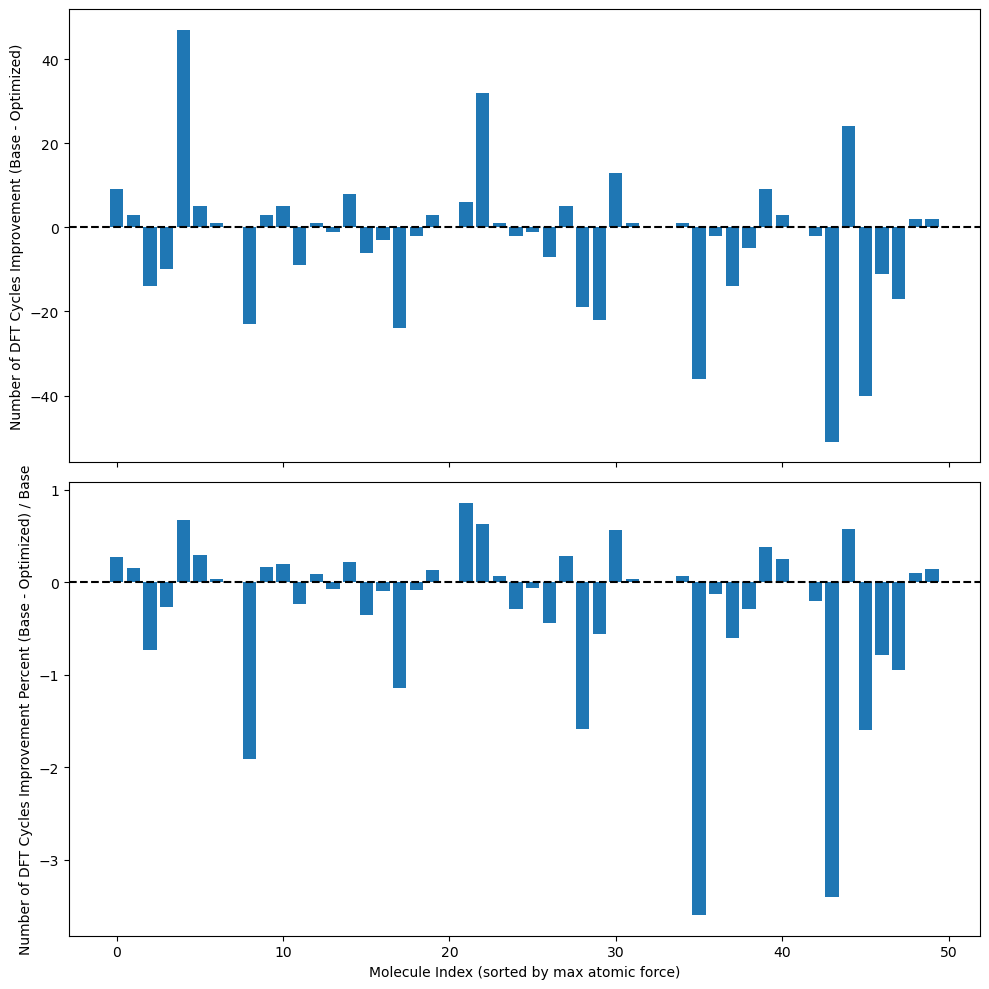

In [91]:
optimization_strategy = "forces_wider_2500"
BO_path = Path(f"BO/optimizations_{optimization_strategy}/")

num_cycles_vs_atomic_force = {}

for molecule, results in num_cycles.items():
    if results["base"] < 0 or results["optimized"] < 0:
        continue

    num_cycles_improvement = results["base"] - results["optimized"]
    num_cycles_improvement_percent = (results["base"] - results["optimized"]) / results[
        "base"
    ]

    with open(BO_path / molecule / "BO_results.json", "r") as f:
        bo_results = json.load(f)

    max_atomic_force_improvement = (
        bo_results["initial_value"] - bo_results["best_value"]
    )
    # max_atomic_force_improvement = bo_results["initial_value"]

    num_cycles_vs_atomic_force[molecule] = {
        "num_cycles_improvement": num_cycles_improvement,
        "num_cycles_improvement_percent": num_cycles_improvement_percent,
        "max_atomic_force_improvement": max_atomic_force_improvement,
    }

num_cycles_vs_atomic_force = list(num_cycles_vs_atomic_force.items())
num_cycles_vs_atomic_force.sort(
    key=lambda x: x[1]["max_atomic_force_improvement"], reverse=True
)

num_cycles_vs_atomic_force = num_cycles_vs_atomic_force[:50]
print(num_cycles_vs_atomic_force)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

ax[0].bar(
    [x for x in range(len(num_cycles_vs_atomic_force))],
    [x[1]["num_cycles_improvement"] for x in num_cycles_vs_atomic_force],
)
ax[0].axhline(0, color="black", linestyle="--")
ax[0].set_ylabel("Number of DFT Cycles Improvement (Base - Optimized)")

ax[1].bar(
    [x for x in range(len(num_cycles_vs_atomic_force))],
    [x[1]["num_cycles_improvement_percent"] for x in num_cycles_vs_atomic_force],
)
ax[1].axhline(0, color="black", linestyle="--")
ax[1].set_xlabel("Molecule Index (sorted by max atomic force)")
ax[1].set_ylabel("Number of DFT Cycles Improvement Percent (Base - Optimized) / Base")

plt.tight_layout()